# Sarcasm Detection in News Headlines with Neural Nets

### Loading the data

In the following we will use the **News Headlines Dataset For Sarcasm Detection** by *Rishabh Misra* to build a classifier that can distinguish sarcastic news from serious ones.

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
import itertools

# 0 - no sarcasm, 1 - sarcasm
data = pd.read_csv("https://raw.githubusercontent.com/michabirklbauer/hgb_dse_text_mining/master/data/Sarcasm/sarcasm.csv")
data.head()

,Headline,Label
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


### A glimpse at class distributions and baseline

Baseline:  0.5610468381444457


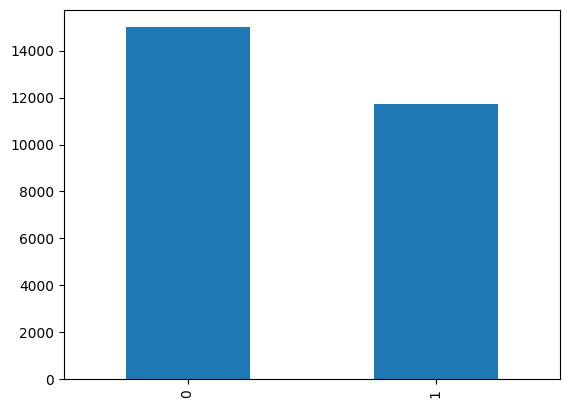

In [2]:
print("Baseline: ", data["Label"].value_counts()[0] / data.shape[0])
data["Label"].value_counts().plot(kind = "bar");

### Splitting data into a training, validation and test partition to be able to evaluate our model

In [3]:
not_test, test = train_test_split(data, test_size = 0.2, random_state = 1337)
train, val = train_test_split(not_test, test_size = 0.3, random_state = 1337)
print(train.shape)
print(val.shape)
print(test.shape)

(14956, 2)
(6411, 2)
(5342, 2)


### We will use Keras to build our neural net

In [4]:
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

### Model parameters

- We will use a vocabulary size of 10 000
- We will create word vectors of length 16
- Our texts will be max 100 words long
  - If they are shorter we will zero-pad them at the end
  - If they are longer we will truncate them to 100 from the end
- Our Out-Of-Vocabulary token will be \<OOV>

In [5]:
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type = "post"
padding_type = "post"
oov_token = "<OOV>"

### Fit the tokenizer to the texts and generate equal length sequences

In [6]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_token)
tokenizer.fit_on_texts(train["Headline"])

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(train["Headline"])
training_padded = pad_sequences(training_sequences, maxlen = max_length, padding = padding_type, truncating = trunc_type)

validation_sequences = tokenizer.texts_to_sequences(val["Headline"])
validation_padded = pad_sequences(validation_sequences, maxlen = max_length, padding = padding_type, truncating = trunc_type)

testing_sequences = tokenizer.texts_to_sequences(test["Headline"])
testing_padded = pad_sequences(testing_sequences, maxlen = max_length, padding = padding_type, truncating = trunc_type)

In [7]:
train.head()

,Headline,Label
19575,celebrating christmas,0
21540,new tsa precheck program offers expedited inte...,1
371,"meet the other baldwin brother, james!",1
15671,"backing devos repeal of obama rules, for-profi...",0
22616,hillary clinton says she's not ready to take a...,0


Bigger index of the word -> less frequent

In [8]:
training_sequences[:5]

[[3382, 348],
 [12, 5575, 1, 1097, 738, 1, 1, 6, 570, 1312],
 [410, 4, 151, 2988, 987, 315],
 [3910, 1846, 1030, 3, 66, 647, 6, 2413, 3383, 7177, 266],
 [152, 85, 55, 499, 29, 411, 2, 183, 7, 1502, 8, 1098, 5576, 458]]

In [9]:
training_padded[:5]

array([[3382,  348,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0],
       [  12, 5575,    1, 1097,  738,    1,    1,    6,  570, 1312,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    

In [10]:
training_padded = np.array(training_padded)
training_labels = np.array(train["Label"])
validation_padded = np.array(validation_padded)
validation_labels = np.array(val["Label"])
testing_padded = np.array(testing_padded)
testing_labels = np.array(test["Label"])

### Building our model

In [11]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length = max_length))
model.add(GlobalAveragePooling1D())
model.add(Dense(24, activation = "relu"))
model.add(Dense(1, activation = "sigmoid"))

# callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
callbacks = []
callbacks.append(EarlyStopping(monitor = "val_loss", patience = 5, verbose = 0, mode = "auto"))
callbacks.append(ModelCheckpoint("sarcasm_check_.h5", save_best_only = True, monitor = "val_loss", mode = "min"))

model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           160000    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


### Training the model on our data

Compare the training with and without callbacks!

In [13]:
# callbacks = []

In [14]:
history = model.fit(training_padded, training_labels, epochs = 30 , validation_data = (validation_padded, validation_labels), callbacks = callbacks, verbose = 1)

Epoch 1/30
468/468 [==============================] - 2s 2ms/step - loss: 0.6767 - accuracy: 0.5608 - val_loss: 0.6371 - val_accuracy: 0.7576
Epoch 2/30
468/468 [==============================] - 1s 2ms/step - loss: 0.4949 - accuracy: 0.7942 - val_loss: 0.4375 - val_accuracy: 0.7879
Epoch 3/30
468/468 [==============================] - 1s 2ms/step - loss: 0.3417 - accuracy: 0.8626 - val_loss: 0.3689 - val_accuracy: 0.8400
Epoch 4/30
468/468 [==============================] - 1s 2ms/step - loss: 0.2783 - accuracy: 0.8913 - val_loss: 0.3487 - val_accuracy: 0.8531
Epoch 5/30
468/468 [==============================] - 1s 2ms/step - loss: 0.2376 - accuracy: 0.9093 - val_loss: 0.3440 - val_accuracy: 0.8537
Epoch 6/30
468/468 [==============================] - 1s 2ms/step - loss: 0.2077 - accuracy: 0.9215 - val_loss: 0.3458 - val_accuracy: 0.8517
Epoch 7/30
468/468 [==============================] - 1s 2ms/step - loss: 0.1788 - accuracy: 0.9349 - val_loss: 0.3555 - val_accuracy: 0.8509
Epoch 

### Plot training history

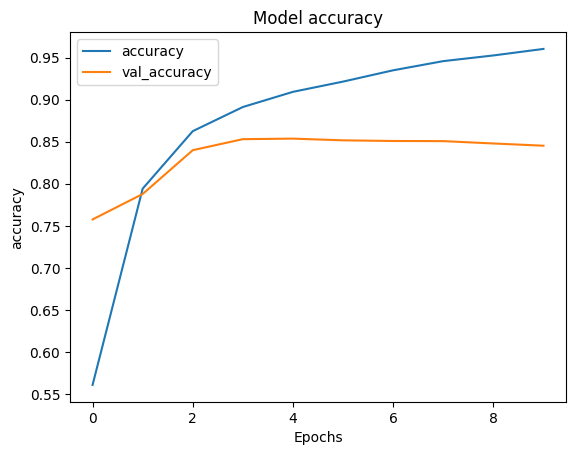

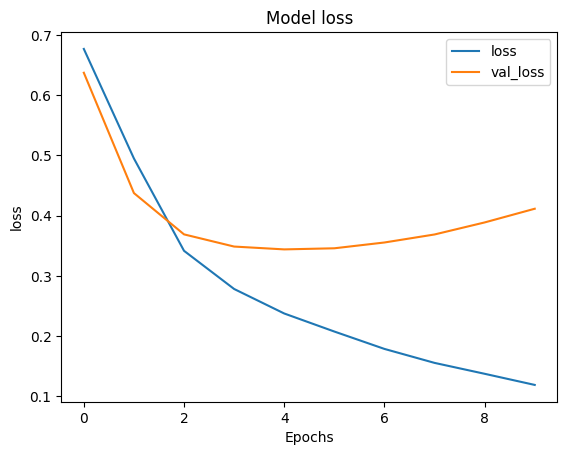

In [15]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history["val_" + metric])
    plt.title("Model " +  metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, "val_" + metric])
    plt.show()
    
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

### Load best-on-validation model

In [16]:
from tensorflow.keras.models import load_model
model = load_model("sarcasm_check_.h5")

### Get predictions

In [17]:
sentences = ["single woman getting all dolled up to watch room full of people make out this new year's eve", "there were some things to cheer in donald trump's wild press conference"]
sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen = max_length, padding = padding_type, truncating = trunc_type)
print(model.predict(padded))

1/1 [==============================] - 0s 64ms/step
[[0.94501495]
 [0.01972622]]


In [18]:
predictions_train = np.where(model.predict(training_padded) > 0.5, 1, 0)
predictions_val = np.where(model.predict(validation_padded) > 0.5, 1, 0)
predictions_test = np.where(model.predict(testing_padded) > 0.5, 1, 0)

167/167 [==============================] - 0s 627us/step


### Evaluate model

In [19]:
print("Training Accuracy: ", accuracy_score(train["Label"], predictions_train))
print("Validation Accuracy: ", accuracy_score(val["Label"], predictions_val))
print("Testing Accuracy: ", accuracy_score(test["Label"], predictions_test))

Training Accuracy:  0.926584648301685
Validation Accuracy:  0.8536889720792388
Testing Accuracy:  0.850430550355672


In [20]:
def plot_confusion_matrix(cm, classes, normalize = False, title = "Confusion matrix", cmap = plt.cm.Blues):

    plt.imshow(cm, interpolation = "nearest", cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype("float") / cm.sum(axis = 1)[:, np.newaxis]
        print("Normalized confusion matrix")

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment = "center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylim(len(cm) - 0.5, -0.5)
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    
    return cm

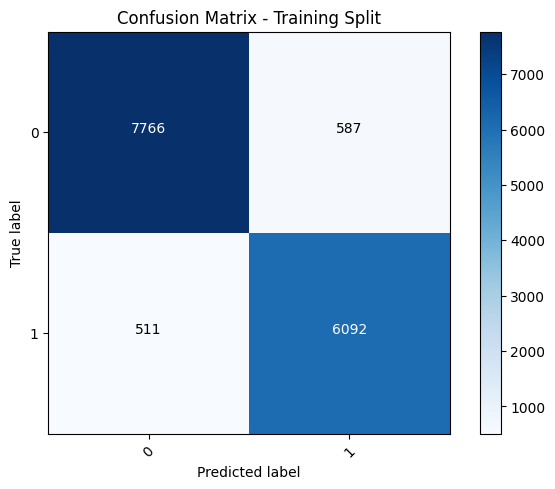

In [21]:
conf = confusion_matrix(train["Label"], predictions_train)

plt.figure()
plot = plot_confusion_matrix(conf, classes = [0, 1], title = "Confusion Matrix - Training Split")
plt.show()

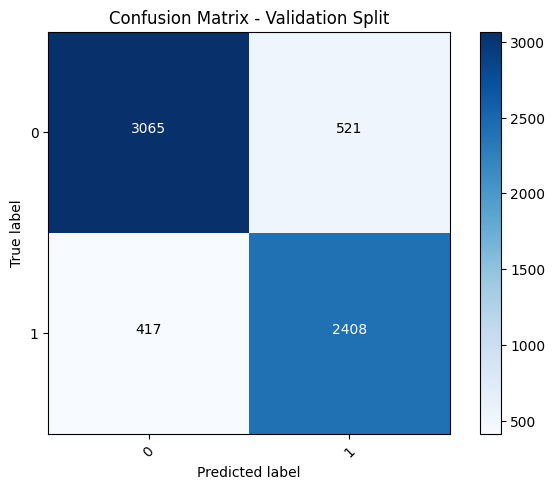

In [22]:
conf = confusion_matrix(val["Label"], predictions_val)

plt.figure()
plot = plot_confusion_matrix(conf, classes = [0, 1], title = "Confusion Matrix - Validation Split")
plt.show()

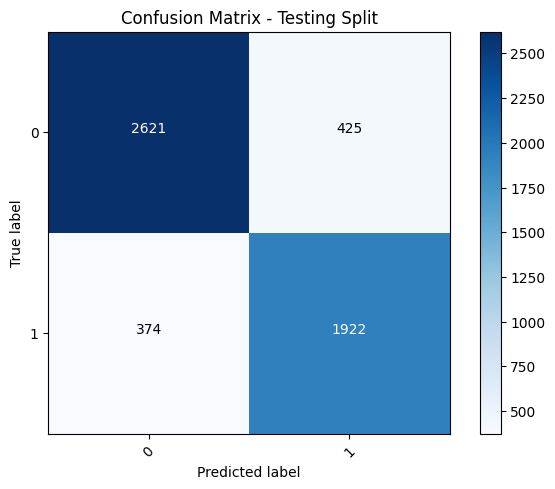

In [23]:
conf = confusion_matrix(test["Label"], predictions_test)

plt.figure()
plot = plot_confusion_matrix(conf, classes = [0, 1], title = "Confusion Matrix - Testing Split")
plt.show()

### By generating a reverse index we can also decode our sequences again...

In [24]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return " ".join([reverse_word_index.get(i, "?") for i in text])

print(decode_sentence(training_padded[0]))

celebrating christmas ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?


### ...combining that with the weights from our embedding layer we can extract the word vectors that we trained

In [25]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 16)


In [26]:
import io

out_v = io.open("vecs.tsv", "w", encoding = "utf-8")
out_m = io.open("meta.tsv", "w", encoding = "utf-8")
for word_num in range(1, vocab_size):
    word = reverse_word_index[word_num]
    embeddings = weights[word_num]
    out_v.write("\t".join([str(x) for x in embeddings]) + "\n")
    out_m.write(word + "\n")
out_v.close()
out_m.close()

In [27]:
# set colab to true and run this cell if you are working in Google Colab to download the generated files
colab = False
if colab:
    try:
        from google.colab import files
    except ImportError:
        pass
    else:
        files.download("vecs.tsv")
        files.download("meta.tsv")

### We can load these files in [http://projector.tensorflow.org/](http://projector.tensorflow.org/) to visualize our embeddings

When we sphereize this data we get two clusters because we did binary classification.

And clicking a word will show you the closest words in the vector space.

# Sentiment Analysis with Transformer Models

### Loading the data

For this task we will use a sample of the **Amazon Fine Food Reviews Dataset** by *Stanford Network Analysis Project*.

In [28]:
data = pd.read_csv("https://raw.githubusercontent.com/michabirklbauer/hgb_dse_text_mining/master/data/AmazonReviews/Reviews_sample.csv")
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,321760,B001GQ3E3C,A1JUIR28N40DK8,"Browser ""Browser""",0,0,5,1348444800,Yum,Very happy to find a yummy peanut butter that ...
1,523699,B004779XHI,A2NY9ISFZGYN0I,Cindy W. Mitchell,0,0,5,1321488000,Perfect Cup of Tea (Hot or Cold),This is the best tea I have ever tasted at hom...
2,156783,B0051WBSFI,A1IK1XYGTNVLOW,James L. Dusing,0,0,5,1351209600,Great service,Not only is the popcorn terrific and as advert...
3,303565,B004LVWJSU,A34AA2X54OT6T1,Jo Stump,0,0,4,1344643200,Mistaken price per ounce,I love chives. They have a mild onion flavor....
4,32122,B0009F3SAK,A2TZFHJ8X4APGD,Laura,3,6,5,1316476800,It works!,I would rather not go into details. I will say...


In [29]:
example = data["Text"][0]
print(example)

Very happy to find a yummy peanut butter that is still healthy. Shopping for groceries used to be fun, now I have to check everything I buy for gmo, or harmful ingredients. The whole family loves this peanut butter, so win win!


### We will use TensorFlow models from the *transformers* package

In [30]:
from transformers import AutoTokenizer
from transformers import TFAutoModelForSequenceClassification
from scipy.special import softmax

C:\Users\Micha\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Loading roBERTa

[https://ai.facebook.com/blog/roberta-an-optimized-method-for-pretraining-self-supervised-nlp-systems/](https://ai.facebook.com/blog/roberta-an-optimized-method-for-pretraining-self-supervised-nlp-systems/)

[https://arxiv.org/abs/1907.11692](https://arxiv.org/abs/1907.11692)

In [31]:
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModelForSequenceClassification.from_pretrained(model_name)

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


### Getting roBERTa predictions

In [32]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors = "tf")
    output = model(**encoded_text)
    scores = output[0][0].numpy()
    scores = softmax(scores)
    scores_dict = {
        "roberta_neg" : scores[0],
        "roberta_neu" : scores[1],
        "roberta_pos" : scores[2]
    }
    return scores_dict

print(example)
print(polarity_scores_roberta(example))

Very happy to find a yummy peanut butter that is still healthy. Shopping for groceries used to be fun, now I have to check everything I buy for gmo, or harmful ingredients. The whole family loves this peanut butter, so win win!
{'roberta_neg': 0.008967283, 'roberta_neu': 0.029506335, 'roberta_pos': 0.9615264}


### Sentiment Analysis in 3 lines of code

In [33]:
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis")
sent_pipeline(example)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some layers from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceCla

[{'label': 'POSITIVE', 'score': 0.9996678829193115}]